## detection for whole region

In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
# from datetime import timedelta
# import matplotlib.colors as colors

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
# mask
meshpath = ['/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/1_mesh_mask.nc']
mask_10 = xr.open_dataset(meshpath[0], chunks={"y":100, "x":100}).tmask.isel(z=0).squeeze()
mask_10_base = xr.open_dataset('/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/mesh_mask.nc', chunks={"y":100, "x":100}).tmask.isel(z=0).squeeze()

# bathymetry for eddytools
path_bathy = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT/'

# observational data
obs_path = '/scratch/usr/shkifmmp/master/data/observations/'

#EKE
path_EXP6 = '/scratch/usr/shkifmmp/manusc/data/EXP06/EKE/'

# DATA DETECTION
datapath= '/scratch/usr/shkifmmp/manusc/data/'

In [3]:
def prep_detection(data):
    data = data.where((data.lat < -36) & (data.lat > -65.97), drop=True)
    OW_std_acc = data.OW_std.where(mask_acc).compute()
    OW_acc = data.OW.where(mask_acc).compute()
    vort_acc = data.vort.where(mask_acc).compute()
    data = data.update({'OW_acc': OW_acc,
                        'OW_std_acc': OW_std_acc,
                        'vort_acc': vort_acc})
    return data

In [4]:
def detection(year, model=0, factor=0.2, npix_max=250, npix_min=20, type_d = 0):

    """ Function to detect eddies,
        experiment 'EXP05' if model == 0; else (1) 'EXP06', 
        type_d = 0 (applying acc mask) or else (1): whole region
    """
    
    folder = 'EXP05' if model == 0 else 'EXP06'
    
#     if 'data_int' in globals():
#         del globals()['data_int']
    
    data_int = xr.open_dataset(datapath + folder + '/interpolated/int_data_77.5_69.5_y' + str(year) + '.nc')
    
    if (folder == 'EXP06') & (type_d == 0):
        lat1, lat2= -65, -37
        data_int = prep_detection(data_int)
        ow_data = data_int['OW_std_acc'].values
        ow_name = 'OW_std_acc'
        
    else:
        lat1, lat2= -67, -30
        ow_data = data_int['OW_std'].values
        ow_name = 'OW_std'
    
    # Specify parameters for eddy detection
    detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': str(year) + '-01-01', # time range start
                        'end_time': str(year) + '-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 69.5, # maximum longitude
                        'lat1': lat1, # minimum latitude
                        'lat2': lat2, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': ow_data,#data_int['OW_std'].values, # 
                        'OW_thr_name': ow_name,#'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -factor, # Okubo-Weiss parameter threshold
                        'Npix_min': npix_min, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': npix_max} # maximum number of pixels (grid cells)

    # We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
    # parameter at this level)
    
#     try: #in case the data_int file corresponds to a different one
#         eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW', 'vort')
#         pass
#     except ValueError:
#         globals()['data_int'] = xr.open_dataset(datapath + folder + '/interpolated/int_data_77.5_69.5_y' + str(year) + '.nc')
    
    if type_d == 0:
        eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW_acc', 'vort_acc')
    else:
        eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW', 'vort')

    
    for i in np.arange(0, len(eddies)):
        datestring = str(eddies[i][0]['time'])[0:10]
        with open('/scratch/usr/shkifmmp/manusc/data/' + folder + '/detected/det_typed' + str(type_d) + '_'
              + str(datestring) + '_eddies_OW' + str(factor) + '_npixmax' + str(npix_max) + '_npixmin' + str(npix_min) + '.pickle', 'wb') as f:
            pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
        f.close()
    return detection_parameters

In [ ]:
detection_parameters = detection(1961, model=0, factor=0.2, npix_max=1038, npix_min=10, type_d=1)

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73


In [6]:
def open_eddies(model, factor=0.2, npix_max= 250, npix_min = 20): #later update with model

    folder = 'EXP05' if model == 0 else 'EXP06'
    
    files_tmp = sorted(glob('/scratch/usr/shkifmmp/manusc/data/' + folder + '/detected/det_*'
              + '_eddies_OW' + str(factor) + '_npixmax' + str(npix_max) + '_npixmin' + str(npix_min) + '.pickle'))
    
    eddies = {}
    for i in np.arange(0,len(files_tmp)):
        datestring = files_tmp[i][53:63]
        with open('/scratch/usr/shkifmmp/manusc/data/' + folder + '/detected/det_'
              + str(datestring) + '_eddies_OW' + str(factor) + '_npixmax' + str(npix_max) + '_npixmin' + str(npix_min) + '.pickle', 'rb') as f:
            eddies.update({i: pickle.load(f)})
    return eddies

In [8]:
eddies = open_eddies(1,npix_max=500)

In [12]:
data_int = xr.open_dataset(datapath + 'EXP06/interpolated/int_data_77.5_69.5_y2000.nc')

In [14]:
ow_data = data_int['OW_std'].values
ow_name = 'OW_std'
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '2000-01-01', # time range start
                        'end_time': '2000-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 69.5, # maximum longitude
                        'lat1': -30, # minimum latitude
                        'lat2': -67, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': ow_data,#data_int['OW_std'].values, # 
                        'OW_thr_name': ow_name,#'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.2, # Okubo-Weiss parameter threshold
                        'Npix_min': 20, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 500} # maximum number of pixels (grid cells)

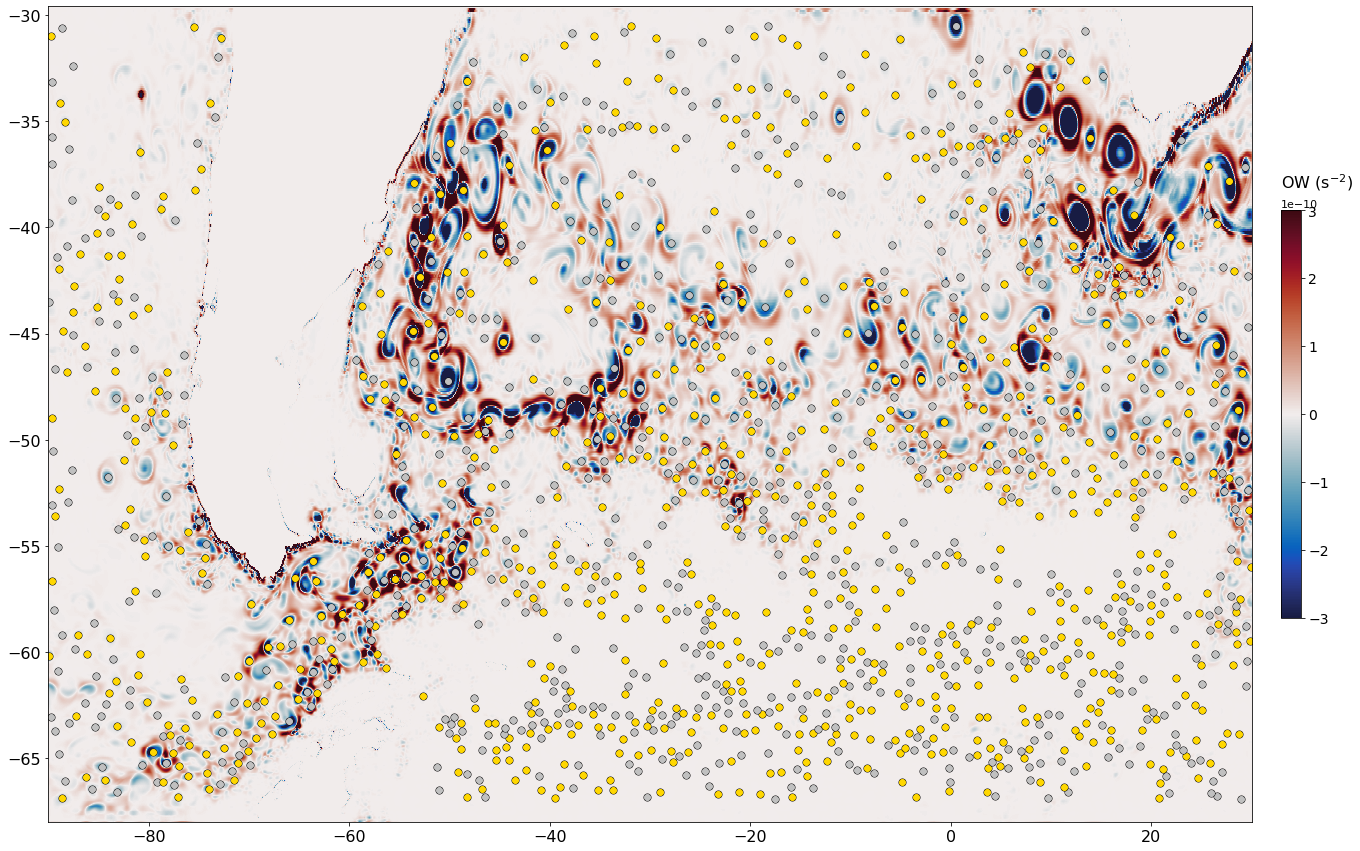

In [17]:
t=70
d_p = detection_parameters
lon1=-90
lon2=30
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(lon1,lon2)) #
# plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values - 360)

plt.figure(figsize=(26,15))
map1 = plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(lon1,lon2)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

# plt.contour(plot_lon, data_int['lat'].values, data_int.mask.sel(lon = slice(-95,17)), colors= 'black')

# for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
#     plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
#              [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
#              color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
#     if eddies[t][i]['lon'] < 0:
    eddy_lon = eddies[t][i]['lon'] #+ 360
#     else:
#         eddy_lon = eddies[t][i]['lon']
    if eddies[t][i]['type'] == 'cyclonic':
        for s, c in zip([7, 6], ['k', 'gold']):
            if (eddies[t][i]['lon'] > lon1) & (eddies[t][i]['lon'] <lon2):
                plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
    elif eddies[t][i]['type'] == 'anticyclonic':
        for s, c in zip([7, 6], ['k', 'silver']):
            if (eddies[t][i]['lon'] > lon1) & (eddies[t][i]['lon'] <lon2):
                plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
#         if (eddies[t][i]['lon'] > lon1) & (eddies[t][i]['lon'] <lon2):
#             plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(map1, pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)